# Run Experiments

This notebook contains the code to run modelling experiments and produces the output for review.

It contains the following sections:

- Imports
- Constants
- Functions
- Import Data
- Feature Selection
- Hyperparameter Tuning
- Cross Validation Results 
- Test Set Results (and model understanding)
- Save Model

## Imports

In [1]:
import os
from typing import (
    Union,
    List,
    Tuple,
    Optional,
    Dict,
    Any,
    Callable,
)
from pathlib import Path
import pickle

import yaml
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    cross_validate,
    GridSearchCV,
)
from sklearn.metrics import (
    make_scorer,
    recall_score,
    precision_score,
    roc_auc_score,
    roc_curve,
)
import pandas as pd
import numpy as np

## Constants

In [2]:
PROCESSED_DATA_PATH = Path(os.getcwd()).parent.joinpath('data').joinpath('processed')
MODEL_SAVE_PATH = Path(os.getcwd()).joinpath('models')

PROCESSED_TRAIN_DATA_FILE = PROCESSED_DATA_PATH.joinpath('train.csv')
PROCESSED_TEST_DATA_FILE = PROCESSED_DATA_PATH.joinpath('test.csv')

exp_config_filename = 'linear_baseline.yaml'

## Functions

In [3]:

def prediction_prop_score(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    **kwargs
) -> float:
    """
    calculates the proportion of the data which is given a positive prediction 
    :param y_true:  np.ndarray not used but required by sklearn to be a scorer
    :param y_pred: np.ndarray predictions from model
    :return: float proportion of positive class predictions
    """
    return y_pred.mean()

def parse_config(config_file: str, experiment_dir: Optional[str] = None) -> Dict[str, Any]:
    """
    Parse the configuration file for the experiment
    :param experiment_dir:  Optional[str] - directory of experiment configuration files
    :param config_file: str - configuration filename
    :return: Dict[str, Any] loaded configuration file for experiment
    """

    if experiment_dir is None:
        experiment_dir = Path(os.getcwd()).joinpath('experiment_configs')
    else:
        experiment_dir = Path(experiment_dir)

    config_file_full = experiment_dir.joinpath(config_file)
    config = yaml.load(open(config_file_full).read(), Loader=yaml.FullLoader)
    config['config_filename'] = str(config_file_full)
    print('config loaded.')

    return config


def column_transformer_factory(
        column_transformer_config: Dict[str, Dict[str, Any]],
        column_transformer_kwargs: Dict[str, Dict[str, Any]],
        transformer_map: Dict[str, Any],
) -> ColumnTransformer:
    """
    Get the actual pipeline requested
    :param column_transformer_config: Dict[str, Dict[str, Any]] - information about required columns transformers
    :param column_transformer_kwargs: Dict[str, Dict[str, Any]] - kwargs for column transformer
    :param transformer_map: Dict[str, Any], - all transformers available to ue for the model pipeline
    :return: Pipeline - model pipeline as requested
    """

    column_transformer_pipeline = []
    for current_trans_id, current_trans_info in column_transformer_config.items():
        column_transformer_pipeline.append(
            (
                current_trans_id,
                transformer_map[current_trans_info['trans_name']](**current_trans_info['trans_args']),
                current_trans_info['col_names'],
            )
        )

    return ColumnTransformer(column_transformer_pipeline, **column_transformer_kwargs)


def pipeline_factory(
        column_trans: ColumnTransformer,
        model_config: Dict[str, Dict[str, Any]],
        transformer_map: Dict[str, Any],
) -> Pipeline:
    """
    Get the actual pipeline requested
    :param column_trans: ColumnTransformer - column tranformations 
    :param model_config: Dict[str, Dict[str, Any]] - ML model information
    :param transformer_map: Dict[str, Any], - all transformers available to ue for the model pipeline
    :return: Pipeline - model pipeline as requested
    """

    model_pipeline = [('column_trans', column_trans)]
    model_pipeline.append((model_config['type'], transformer_map[model_config['type']](**model_config['kwargs'])))
    return Pipeline(model_pipeline)

def make_model(
    exp_config: Dict[str, Any], 
    transformer_map: Dict[str, Any]) -> Pipeline:
    
    """
    Controls the creation of pipelines
    :param exp_config: Dict[str, Dict[str, Any]] - experiment information
    :param transformer_map: Dict[str, Any], - all transformers available to ue for the model pipeline
    :return: Pipeline - model pipeline as requested
    """


    col_trans = column_transformer_factory(
        column_transformer_config=exp_config['column_transformer_map'],
        column_transformer_kwargs=exp_config['column_transformer_args'],
        transformer_map=transformer_map
    )
    model_pipeline = pipeline_factory(
        column_trans=col_trans,
        model_config=exp_config['model'],
        transformer_map=transformer_map
    )
    
    return model_pipeline

known_transformers = (
    ColumnTransformer, 
    SimpleImputer, 
    OneHotEncoder,
    LogisticRegression,
    DummyClassifier,
    RandomForestClassifier,
)

transformer_map = {trans.__name__: trans for trans in known_transformers}




## Load Config

In [4]:
exp_config = parse_config(config_file=exp_config_filename)
exp_config

config loaded.


{'model_name': 'churn__log_reg__baseline.pkl',
 'features_col_names': ['main_operating_route',
  'tenure_years',
  'opened_campaign__processed',
  'total_expenses__processed',
  'num_loads_prev_12_mth__processed',
  'profit_prev_12_mth__processed'],
 'label_col_name': 'churned',
 'column_transformer_map': {'impute': {'trans_name': 'SimpleImputer',
   'trans_args': {},
   'col_names': ['total_expenses__processed',
    'profit_prev_12_mth__processed']},
  'OHE': {'trans_name': 'OneHotEncoder',
   'trans_args': {'drop': 'first'},
   'col_names': ['main_operating_route']}},
 'column_transformer_args': {'remainder': 'passthrough'},
 'model': {'type': 'LogisticRegression',
  'kwargs': {'penalty': 'none',
   'class_weight': 'balanced',
   'random_state': 3142}},
 'n_folds': 5,
 'param_grid': None,
 'best_params': None,
 'config_filename': 'D:\\Git_in_D\\sennder_parent\\modelling\\experiment_configs\\linear_baseline.yaml'}

## Load Data

In [5]:
train_df = pd.read_csv(PROCESSED_TRAIN_DATA_FILE, header=0, index_col=0)

X = train_df[exp_config['features_col_names']]
y = train_df[exp_config['label_col_name']]

display(X)
print('\n')
display(y)

,main_operating_route,tenure_years,opened_campaign__processed,total_expenses__processed,num_loads_prev_12_mth__processed,profit_prev_12_mth__processed
2410,DE_GB,1.815940,0,9.817137,3.258097,9.626934
947,DE_GB,0.481308,0,9.096857,2.944439,8.579335
5950,DE_GB,1.657292,1,10.703430,3.465736,8.916716
348,DE_FR,1.487814,0,9.561450,3.044522,8.784945
3626,DE_GB,1.936974,0,9.201480,3.401197,8.830083
...,...,...,...,...,...,...
4365,DE_GB,2.719490,0,10.496413,3.583519,8.592266
479,DE_FR,0.287605,0,8.913389,3.218876,9.194797
1242,DE_GB,2.348454,0,NaN,3.295837,9.237365
1409,PL_IT,2.151398,0,9.934777,3.526361,8.323035


2410    0
947     1
5950    0
348     0
3626    0
       ..
4365    0
479     0
1242    0
1409    0
1363    0
Name: churned, Length: 5946, dtype: int64

In [6]:
test_df = pd.read_csv(PROCESSED_TEST_DATA_FILE, header=0, index_col=0)

X_test = test_df[exp_config['features_col_names']]
y_test = test_df[exp_config['label_col_name']]

display(X_test)
print('\n')
display(y_test)

,main_operating_route,tenure_years,opened_campaign__processed,total_expenses__processed,num_loads_prev_12_mth__processed,profit_prev_12_mth__processed
0,DE_GB,2.065258,0,11.384912,3.135494,10.059565
2,DE_FR,0.297064,0,8.471638,3.295837,7.102320
10,DE_GB,1.593268,0,10.428440,3.258097,9.106305
16,DE_GB,1.549858,0,10.104388,3.295837,8.867510
20,DE_FR,1.641286,0,11.272943,2.944439,10.252601
...,...,...,...,...,...,...
7359,DE_GB,2.958720,0,8.983136,3.258097,8.469335
7370,DE_GB,0.272627,1,10.733476,2.564949,9.570868
7411,DE_GB,0.800804,1,NaN,3.258097,8.888176
7415,DE_GB,2.419081,0,9.776132,3.295837,9.292369


0       0
2       1
10      0
16      0
20      0
       ..
7359    0
7370    0
7411    0
7415    0
7418    0
Name: churned, Length: 1486, dtype: int64

## Load Model Pipeline

In [7]:
model_pipeline = make_model(exp_config=exp_config, transformer_map=transformer_map)
model_pipeline

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute', SimpleImputer(),
                                                  ['total_expenses__processed',
                                                   'profit_prev_12_mth__processed']),
                                                 ('OHE',
                                                  OneHotEncoder(drop='first'),
                                                  ['main_operating_route'])])),
                ('LogisticRegression',
                 LogisticRegression(class_weight='balanced', penalty='none',
                                    random_state=3142))])

## Feature Selection

TODO - the models already have a relatively small number of features so feature selection so suggest feature selection as a future iteration (note some feature selection was already performed at the preprocessing stage which may not be optimal)

## Hyperparameter Tuning

In [8]:

if exp_config.get('param_grid') is not None:
    g_cv = GridSearchCV(
        model_pipeline,
        exp_config['param_grid'],
        cv=exp_config['n_folds'],
        refit=False,
        scoring='roc_auc'
    )
    g_cv.fit(X, y)
    g_cv.best_params_

## Cross Validation Results

In [9]:
model_pipeline = make_model(exp_config=exp_config, transformer_map=transformer_map)

if 'g_cv' in locals():
    model_pipeline.set_params(**{g_cv.best_params_})

cv_results = cross_validate(
    estimator=model_pipeline,
    X=X,
    y=y,
    cv=exp_config['n_folds'],
    scoring={
        'recall': make_scorer(recall_score), 
        'precision': make_scorer(precision_score), 
        'roc_auc': make_scorer(roc_auc_score), 
        'prediction_prop_score': make_scorer(prediction_prop_score),
    }
    
)
cv_results

{'fit_time': array([0.07901597, 0.07053471, 0.03991961, 0.0597136 , 0.05201888]),
 'score_time': array([0.00716519, 0.00712991, 0.00703311, 0.00731874, 0.00807571]),
 'test_recall': array([0.97777778, 0.94382022, 0.93258427, 0.96629213, 0.96629213]),
 'test_precision': array([0.50285714, 0.45405405, 0.48538012, 0.43877551, 0.46236559]),
 'test_roc_auc': array([0.94934343, 0.92600102, 0.92629213, 0.93314607, 0.93769152]),
 'test_prediction_prop_score': array([0.14705882, 0.15559294, 0.14381833, 0.16484441, 0.15643398])}

In [10]:
for metric_name, metric_results in cv_results.items():
    print(f'{metric_name}: {metric_results.mean()}')
    

fit_time: 0.060240554809570315
score_time: 0.007344532012939453
test_recall: 0.9573533083645444
test_precision: 0.46868648309443844
test_roc_auc: 0.934494836000454
test_prediction_prop_score: 0.15354969574036512


## Test Set Results

TODO - shap value although since the random forest doesn't seem work the additional complexity probably not required at the moment

In [11]:
model_pipeline = make_model(exp_config=exp_config, transformer_map=transformer_map)

if 'g_cv' in locals():
    model_pipeline.set_params(**{g_cv.best_params_})

model_pipeline.fit(X, y)

test_set_predictions = model_pipeline.predict(X_test)

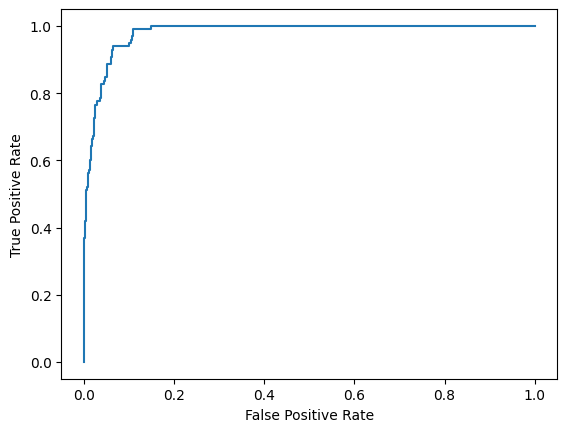

In [12]:

#define metrics
y_pred_proba = model_pipeline.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [13]:
if isinstance(model_pipeline.steps[-1][1], LogisticRegression):
    [ print(i) for i in zip(
        model_pipeline.steps[0][1].get_feature_names_out(),
        model_pipeline.steps[-1][1].coef_[0]
        )
    ]
    print(f'intercpet: {model_pipeline.steps[-1][1].intercept_}')
    
if isinstance(model_pipeline.steps[-1][1], RandomForestClassifier):
     [ print(i) for i in zip(
            model_pipeline.steps[0][1].get_feature_names_out(),
            model_pipeline.steps[-1][1].feature_importances_
            )
        ]


('impute__total_expenses__processed', 0.31237342976700816)
('impute__profit_prev_12_mth__processed', -3.6031302089540693)
('OHE__main_operating_route_DE_GB', 3.38282387065055)
('OHE__main_operating_route_PL_IT', -0.42155290532736234)
('remainder__tenure_years', -6.5147909115956475)
('remainder__opened_campaign__processed', 2.0508193550791574)
('remainder__num_loads_prev_12_mth__processed', 0.01822036725346312)
intercpet: [29.47922657]


In [14]:

metric_functions = (recall_score, precision_score, roc_auc_score, prediction_prop_score)
for current_metric_func in metric_functions:
    print(f'{current_metric_func.__name__}: {current_metric_func(y_test, test_set_predictions)}')

recall_score: 0.9387755102040817
precision_score: 0.416289592760181
roc_auc_score: 0.9229180144680351
prediction_prop_score: 0.148721399730821


## Save Model

In [15]:
if exp_config.get('model_name') is not None:
    model_filename = MODEL_SAVE_PATH.joinpath(exp_config['model_name'])
    with open(model_filename, 'wb') as f:
        pickle.dump(model_pipeline, f)
    print('model saved')

model saved
